In [909]:
#ckh Aug-Sept 2016 trying PES export, bring in a file instead of hard coding
#See if i can get something to show up in StitchBuddy and on my machine
#first without any complicated jumps or color changes.
#Then I need to add jumps so the chariot is pointing in the right direction before stitching.
#I can insert them in the simpler .exp format but StitchBuddy removes these "unnecessary" jumps
#when converting into .pes
import numpy as np

In [910]:
inputfile='TwoSpirals.txt'
outputfile='TwoSpiTest17.pes'

In [911]:
#inputx=np.array([0,5,10,10,10, 5, 0,0,0])*10
#inputy=np.array([0,0, 0, 5,10,10,10,5,0])*10# A little square in mm, converted to PES file units of 0.1mm
#nputy=-inputy #StitchBuddy flips the y-value for some reason

In [912]:
stitchdata= np.loadtxt(inputfile, delimiter=',')
inputx=np.round(np.array(stitchdata[:,0])*10)
inputy=-np.round(np.array(stitchdata[:,1])*10) #load data in mm, convert to integers in 0.1mm units

(-40.0, 40.0, -30.0, 30.0)

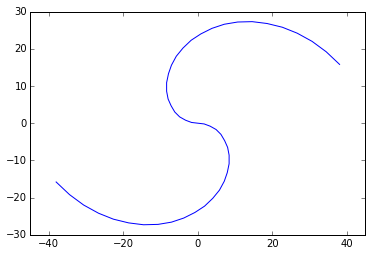

In [913]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(inputx/10,inputy/10)#plot units are mm
plt.axis('equal')

In [914]:
xsize=np.max(inputx)-np.min(inputx)
ysize=np.max(inputy)-np.min(inputy)
YsizeMSB=int(np.trunc(ysize/256))
YsizeLSB=int(ysize-256*YsizeMSB)
XsizeMSB=int(np.trunc(xsize/256))
XsizeLSB=int(xsize-256*XsizeMSB)
XsizeMSB,XsizeLSB,YsizeMSB,YsizeLSB #gonna be used later

(2, 250, 2, 34)

In [915]:
NumberOfStitches=len(inputx)
NumStitchMSB=int(np.trunc(NumberOfStitches/256))
NumStitchLSB=int(NumberOfStitches-NumStitchMSB*256)
NumStitchMSB,NumStitchLSB #will be used later

(0, 49)

In [916]:
#Positions of items in PES files, for Python where vectors start at 0
PECstartloc=8
NumColorLocOffset=48 #related to where to find number of colors in the file
#Trever Adams has 48, this seems to match what StitchBuddy does. usually put 0 (one color)
ColorLocOffset=49 #this is what Achatina mentions, it refers to the start of the color table
#the next few bytes would hold additional color values but USUALLY only have one color
#so I did not handle more bytes here yet.
GraphicLocOffset=514 #matches what Trever Adams has
SizeLocOffset=520 #it's related to where we will write the x and y extents
StitchStartOffset=532 #it's related to where we will start the cumulative stitch data
StitchEndOffset=512 #it's related to where the stitch data will end



In [917]:
#Bytes 0-7 are a header
PESdatastart=[35, 80, 69, 83, 48, 48, 48, 49] # writes #PES0001 at start of file

#Bytes 8, 9 and 10 give location data for the graphics. I will come back to it later on.
PESsection1=[0,0,0]

#Bytes 11 through 30
PESsection2=[0, 0, 0, 1, 0, 1, 0, 255, 255, 0, 0, 7, 0, 67, 69, 109, 98, 79, 110, 101] #7 0 CEmbOne
#The pattern seems consistent between different files

In [918]:
#PESsection3
#Bytes 31-46 differ between patterns. 
#In a square data file, the last 2 bytes were a copy of the first 2
##Other people are saying this is min X, min Y , max X, max Y
#But I'm not finding those minX and minY values in the file. And they are all positive. Their
#difference matches the width (x) and height(y) respectively but there is
#some large positive offset. It turns out, this offset centers the bounding box
#at 1000,1000(10 cm, 10 cm) from which min X, min Y, max X, and max Y are calculated,
#keeping all the range-numbers positive I guess for a 4-inch hoop
minXMSB=int(np.trunc(np.min(1000+inputx)/256))
minXLSB=int(np.min(1000+inputx)-256*minXMSB)
minYMSB=int(np.trunc(np.min(1000+inputy)/256))
minYLSB=int(np.min(1000+inputy)-256*minYMSB)
maxXMSB=int(np.trunc(np.max(1000+inputx)/256))
maxXLSB=int(np.max(1000+inputx)-256*maxXMSB)
maxYMSB=int(np.trunc(np.max(1000+inputy)/256))
maxYLSB=int(np.max(1000+inputy)-256*maxYMSB)
PESsection3=[minXLSB, minXMSB, minYLSB, minYMSB, maxXLSB, maxXMSB, maxYLSB, maxYMSB]
PESsection3=PESsection3*2 #Both files repeat the 8 bytes 2x
#Maybe they expect a bigger hoop in another version of the format
#Meanwhile, the PE525 machine may be using this info to select a hoop but it IGNORES these XY endpoints
#and puts the centroid of the bounding box at 0,0 during stitching
#PESsection3=[232,3,232,3,232,3,232,3]*2
#StitchBuddy has 232,3 instead of 76,4. Trying that out instead to see if my pattern appears.
PESsection3

#it is def running into the upper wall at 249,4 because of a wrong offset.

[107, 2, 215, 2, 101, 5, 249, 4, 107, 2, 215, 2, 101, 5, 249, 4]

In [919]:
#Another consistent stretch between bytes 47 and 72, there's a discrepancy btw what Stitchbuddy
#produces and what Trever Adams finds, he has 0,0,0,0,0,0,0,0 instead of 0,0, 122,68,0,0,122,68
PESsection4=[0, 0, 128, 63, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 63, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0];

In [920]:
#PESsection5. ok except all my examples are for a centered design
#and the 1cm square here is not centered.
#Bytes 73-80 are different between files. Bytes 77-78 are x extent
#and bytes 79-80 are y-extent. 73-74 246 255 in both rotated and unrotated,
#75 76 y-offset  250 0 vs 236 0 in the rotated one.
#PESsection5=[XoffsetLSB XoffsetMSB YoffsetLSB YoffsetMSB XsizeLSB XsizeMSB YsizeLSB YsizeMSB];
#For now. The  bytes 73-80 are supposed to be "offsets" but from what? 
#These offsets turn out to be just half the size. But also, if you add the y offset to
#1000 you get supposed max Y from PESSection3, and if you subtract the x offsset 
#from 1000 you get the alleged max X from PESSEction3.
#I am reading online that some of these numbers should be the design X offset, design Y offset (Treveradams/libpes on Github) *******Another place to check.
#But also minimal X of all stitches in CSewSeg, max Y of all stitches in CSewSeg. That doesn't seem like the same thing.
XoffsetMSB=int(np.trunc(xsize/256/2))
#XoffsetMSB=0;
XoffsetLSB=int(xsize/2-256*XoffsetMSB)
#XoffsetLSB=0;#what StitchBuddy is producing that works
YoffsetMSB=int(np.trunc(ysize/256/2))
#YoffsetMSB=0;
YoffsetLSB=int(ysize/2-256*YoffsetMSB)
#YoffsetLSB=0;
PESsection5=[XoffsetLSB,XoffsetMSB,YoffsetLSB,YoffsetMSB,XsizeLSB,XsizeMSB,YsizeLSB,YsizeMSB]
PESsection5=[0,0,0,0,0,0,0,0]
#StitchBuddy puts 0s for these offsets. 

In [921]:
#PESsection 6, bytes 81-88 consistent between files and is filled with 0s
PESsection6=[0,0,0,0,0,0,0,0]
#PESsection 7=?
#It is a single byte, at 89, that differs between files
PESsection7=[0] #"professionally designed files seem to have 1 here" (Trever Adams). But StitchBuddy puts 0.

In [922]:
#PESsection 8, bytes 90-103 are consistent between files
PESsection8=[0, 255, 255, 0, 0, 7, 0, 67, 83, 101, 119, 83, 101, 103] #0, section break [255 255 0 0] then 7 0 CSewSeg

In [923]:
#PESsection 9 -different and different length between files!!!
#one file has 16 more bytes here
#than the other. Bytes 104-107 
#Other online info says it's about colors.
#Color Start Indicator, Color Index says http://www.njcrawford.com/programs/embroidery-reader/pes0001/
#For both the final byte is 0 and maybe that is the color index?
#PESsection9=[ColorChangeIndLSB ColorChangeIndMSB ColorIndexLSB ColorIndexMSB 
#    NumberOfStartupStitchesLSB NumberOfStartupStitchesMSB XCoord1LSB XCoord1MSB
#    YCoord1LSB YCoord1MSB..XCoordNLSB...6 more bytes];%Get a few more examples to figure section 9 out. There is
#    something about a rotation matrix here but that seems to be PES version 7
# StitchBuddy gives 
PESsection9=[0, 0,  39,   0]


In [924]:
#PESsection 10 - 2 bytes giving the number of stitches, LSB first
PESsection10=[NumStitchLSB, NumStitchMSB]
PESsection10  #Doh StitchBuddy is only finding eight stitches. it ignores the 0,0 starting stitch

[49, 0]

In [925]:
#Then add on the absolute stitch coords as 2 byte xy values. StitchBuddy has all my stitches as follows:
#(50,0  0,0) (100,0 0,0) (100,0, 206,255 --a y value of -5 mm) (100,0 156,255-- a y value of -10 mm) (50,0 156,255)
#(0,0 156,255) (0,0, 206,255) (0,0 0,0) 
#How weird that it seems like StitchBuddy flipped the y values to negative ones. I put a - sign on inputy for this reason
#There are 8 stitches. #perhaps here I can put in the 9th stitch and get it right...start the above sequence with (0,0 0,0)
PESsection11=[50,0,0,0,100,0,0,0,100,0,206,255,100,0,156,255,50,0,156,255,0,0,156,255,0,0,206,255,0,0,0,0] #AbsStitchCoords
stitchpile=np.array(zip(inputx,inputy)).flatten()

def msb8(st):
    if np.abs(st) > 32767:
        print "warning: stitch found more than 32.7 cm from origin, pattern too large"
        return np.uint8(127*np.sign(st)) #just assign it the max value 
    else:
        return np.uint8(np.trunc(st/256))

def lsb8(st):
    return np.uint8(st-256*msb8(st))

    
#I used np.uint8(), this works to translate the negative numbers but it will wrap around, np.uint8(500) =12
PESsection11=[byte for s in stitchpile for byte in [lsb8(s),msb8(s)] ]  #create msb8 and lsb8 functions
#the order of operations is alien to me but it's like
#(for s in stitchpile)  gets every x or y stitch coord and calls it s
#then [lsb8(s),msb8(s)] is a length 2 list of the LSB and MSB of that stitch in uint8 format
#then, take each byte in [lsb8(s),msb8(s)] and add it to the list
#It would be more readable to flatten a structured list
#that I would create by [[lsb8(s),msb8(s)] for s in stitchpile]
#but Python doesn't have flatten (numpy does). 
#they refused to create a flatten function bc generally, lists of lists can have irregular shapes
#and then flatten is ambiguous
#Coming from Matlab I expect it all to be a rectangle, & there's a clear plan for exactly how flatten will work 
PESsection11


[131,
 255,
 98,
 0,
 167,
 255,
 64,
 0,
 205,
 255,
 36,
 0,
 245,
 255,
 14,
 0,
 29,
 0,
 254,
 255,
 70,
 0,
 244,
 255,
 110,
 0,
 239,
 255,
 149,
 0,
 240,
 255,
 185,
 0,
 246,
 255,
 218,
 0,
 1,
 0,
 248,
 0,
 16,
 0,
 18,
 0,
 33,
 0,
 40,
 0,
 54,
 0,
 58,
 0,
 76,
 0,
 71,
 0,
 100,
 0,
 79,
 0,
 123,
 0,
 84,
 0,
 147,
 0,
 84,
 0,
 170,
 0,
 80,
 0,
 191,
 0,
 72,
 0,
 209,
 0,
 62,
 0,
 226,
 0,
 49,
 0,
 239,
 0,
 33,
 0,
 248,
 0,
 17,
 0,
 254,
 0,
 0,
 0,
 0,
 0,
 239,
 0,
 2,
 0,
 223,
 0,
 8,
 0,
 207,
 0,
 17,
 0,
 194,
 0,
 30,
 0,
 184,
 0,
 47,
 0,
 176,
 0,
 65,
 0,
 172,
 0,
 86,
 0,
 172,
 0,
 109,
 0,
 177,
 0,
 133,
 0,
 185,
 0,
 156,
 0,
 198,
 0,
 180,
 0,
 216,
 0,
 202,
 0,
 238,
 0,
 223,
 0,
 8,
 0,
 240,
 0,
 38,
 0,
 255,
 0,
 71,
 0,
 10,
 1,
 107,
 0,
 16,
 1,
 146,
 0,
 17,
 1,
 186,
 0,
 12,
 1,
 227,
 0,
 2,
 1,
 11,
 1,
 242,
 0,
 51,
 1,
 220,
 0,
 89,
 1,
 192,
 0,
 125,
 1,
 158,
 0]

In [926]:
#Then StitchBuddy puts this, I dont know what it means yet
PESsection12=[1,0,0,0,39,0,0,0,0,0]


In [927]:
#The next section from pecstart:pecstart+49 is...perhaps some labels, this looks like chars
#[76, 65, 58, 49, 99, 109, 83, 113, 117, 97, 114,101,84,101,115,116,32,32,32,13 ] 
#Yes it is [L A : 1 c m S q u a r e T e s t (space=32) (space) (space) (cr=13)]
#It could be a 16 char label, filled out by spaces, and then a carriage retrn
#Then all this looking like spaces and a few control characters, maybe these could hold names for colors
#32,32,32,32,32,32,32,32,32,32,32,32,255,0,6,38,32,32,32,32,32,32,32,32,32,32,32,32]

#Therefore pecstart is calculated as len(everthing up to and including PESsection12)
PECsection1=[76, 65, 58]# LA:
#use ord('a') to convert my output filename to a label. why not atoi or int, where ever did they get ord
labelname=outputfile.split('.',1) #get first 16 chars before any dot in the filename
mylabel=[ord(s) for s in labelname[0]]
mylabel=mylabel[0:16]
mylabel=mylabel+[32]*(16-len(mylabel))+[13]
PECsection1=PECsection1+mylabel+[32,32,32,32,32,32,32,32,32,32,32,32,255,0,6,38,32,32,32,32,32,32,32,32,32,32,32,32]

In [928]:
#now a familiar neighborhood vx[pecstart+49]=0  #number of colors in file is
PECsection2=[0]#Number of Colors in File, for single color files I see 0 a lot, so maybe its num of color changes?

In [929]:
#THEN there is a 39, which is probably a color index. Then it's filled with spaces  (32s) 
#Followed by [0,0] up to and including vx[pecstart+514]
PECsection3=[39] + [32]*(GraphicLocOffset-NumColorLocOffset-4)
PECsection3=PECsection3+[0,0]

In [930]:
#Then we have a [37,0,0] which is "graphic" location for this design-- it will vary--is calculated from the data
#I need to figure out later on while building the output vector.
#pecstart+GraphicLocOffset=LSB of graphic, pecstart+515 &516 are the remaining bytes
PECsection4=[0,0,0]#graphic - placeholder till vector is assembled


In [931]:
#Then [49,255,240] -- is it the same for different files? vx[pecstart+518:pecstart+521]
PECsection5=[49,255,240] #unknown meaning

In [932]:
#Then [XsizeLSB,XsizeMSB,YsizeLSB,YsizeMSB] #vx[pecstart+521:pecstart+525]
PECsection6=[XsizeLSB,XsizeMSB,YsizeLSB,YsizeMSB]
PECsection6

[250, 2, 34, 2]

<H2>SOMETHING HERE CHANGES THE OFFSET OF THE PATTERN CENTER:</H2>

In [933]:
#the lowest x value is also the value of the initial jump
#however the highest y value is not at the start
#I need to move the pattern down by ysize/2-inputy[0]
startYoff=ysize/2+inputy[0]
startXoff=xsize/2+inputx[0]
startXoff,startYoff
#now I have to convert the last two byte pairs in PECsection7 to these offsets
#using the jump stitch method

def jumpit(displ):
    if displ >=0: #positive jump
        #check here for jump too large, 8*256 or 2048 (204.8 mm) and above are too large
        if displ>2047:
            print "Error, jump greater than 204.7 mm found"
        msb=np.trunc(displ/256)
        lsb=np.trunc(displ-msb*256)
        firstbyte=128+msb
        secondbyte=lsb
        return firstbyte,secondbyte
    else:#negative jump
        if displ < -2047:
            print "Error, jump greater than 204.7 mm found"
        msb=15-np.trunc(-displ/256)
        lsb=256+(displ+msb*256)  #need to check this
        firstbyte=128+msb
        secondbyte=lsb
        
startXoff,startYoff,jumpit(startXoff)[0],jumpit(startXoff)[1],jumpit(startYoff)[0],jumpit(startYoff)[1]
    

(0.0, 115.0, 128.0, 0.0, 128.0, 115.0)

In [934]:
#Then [224, 1, 176, 1, 144, 50, 144, 50] # I am guessing this part varies between designs, it looks squarish
PECsection7=[224, 1, 176, 1, 128, 0, 128, 115] #unknown meaning, first 4 are fixed 
#and last 4 change where the design center winds up in StitchBuddy
#[224,1,176,1, jump to CENTER , rest of jump to X CENTER, jump to Y CENTER, rest of jump to Y CENTER]
PECsection7=[224,1,176,1,jumpit(startXoff)[0],jumpit(startXoff)[1],jumpit(startYoff)[0],jumpit(startYoff)[1]]

In [935]:
diffx=np.diff(inputx)
diffy=np.diff(inputy)
#diffx[3]=100 #Testing what happens if a stitch is greater than the max length of 63
diffpile=np.array(zip(diffx,diffy)).flatten()
def stitchdisp(s):
    if 0<=s<=63:
        return s,0
    else:
        if -63<=s<=-1:
            return 128+s,0
        else:
            stitchLengthError=s
            return s,stitchLengthError

#PECsection8=[50, 0, 50, 0, 0, 78, 0, 78, 78, 0, 78, 0, 0, 50, 0, 50]  #This is the 7 bit encoded displacement data.
PECsection8=[stitchdisp(s)[0] for s in diffpile]
PECtoolongs=[stitchdisp(s)[1] for s in diffpile]#save locations of any too-long stitches along with their lengths
#PECsection8,PECtoolongs

In [936]:
#Then [255]
PECsection9=[255]#end of stitch data. Achatina and Trever Adams has [255 0] but StitchBuddy leaves off the 0

In [937]:
#Immediately after comes the 228 byte pixel graphic that gets displayed on the LCD
#It's in a strange format, so I have to reverse how I decoded it in MATLAB.
#And before that, must create a bitmap based on the stitch pattern.
#vx[pecstart+graphic+513:pecstart+graphic+513+228]

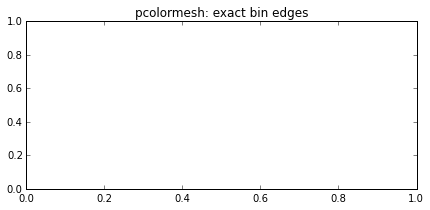

In [938]:
#Generate a black/white graphic by thresholding a histogram?
import matplotlib as mpl
import matplotlib.pyplot as plt
H,yedges,xedges=np.histogram2d(inputy,inputx,bins=[39,48])
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(111)
ax.set_title('pcolormesh: exact bin edges')
xcenters = xedges[:-1] + 0.5 * (xedges[1:] - xedges[:-1])
ycenters = yedges[:-1] + 0.5 * (yedges[1:] - yedges[:-1])
X,Y = np.meshgrid(xcenters, ycenters)
X.shape,Y.shape,H.shape #Caught annoying problem with pcolormesh
#ax.pcolormesh(X, Y, H,cmap='RdBu')
#ax.set_aspect('equal')
#plt.show()

#histogram works meh, it doesn't really resemble plot for sparse drawings
#why dont I instead scale it to 100x100 mm & mark a point in the 39x48 array "1" if it contains any data at all
#meanwhile just put a copy of what StitchBuddy produced
#PECsection10=[0]*228 #zeroes didn't work
PECsection10=[0,
 0,
 0,
 0,
 0,
 0,
 240,
 255,
 255,
 255,
 255,
 15,
 8,
 0,
 0,
 0,
 0,
 16,
 4,
 0,
 0,
 0,
 0,
 32,
 2,
 0,
 0,
 0,
 0,
 64,
 2,
 252,
 255,
 255,
 63,
 64,
 2,
 252,
 255,
 255,
 63,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 0,
 0,
 48,
 64,
 2,
 12,
 128,
 255,
 63,
 64,
 2,
 12,
 128,
 255,
 63,
 64,
 2,
 0,
 0,
 0,
 0,
 64,
 4,
 0,
 0,
 0,
 0,
 32,
 8,
 0,
 0,
 0,
 0,
 16,
 240,
 255,
 255,
 255,
 255,
 15,
 0,
 0,
 0,
 0,
 0,
 0]


In [939]:
#Finally tack on another copy of the 228 byte pixel graphic. vx[pecstart+graphic+513+228:] is same as above. That is all
PECsection11=PECsection10

In [940]:
#Concatenate everything up to just before the PEC block and then calculate length
vx=PESdatastart+PESsection1+PESsection2
vx=vx+PESsection3+PESsection4+PESsection5
vx=vx+PESsection6+PESsection7+PESsection8
vx=vx+PESsection9+PESsection10+PESsection11+PESsection12

pecstartValue=len(vx)
pecstartValueMSB=np.trunc(pecstartValue/65536)
pecstartValueMiddleBit=np.trunc((pecstartValue-65536*pecstartValueMSB)/256)
pecstartValueLSB=int(pecstartValue-pecstartValueMSB*65536-pecstartValueMiddleBit*256)
pecstartValueMSB=int(pecstartValueMSB)
pecstartValueMiddleBit=int(pecstartValueMiddleBit)

#Fill in values for pecstart at pecstart location
vx[PECstartloc]=pecstartValueLSB
vx[PECstartloc+1]=pecstartValueMiddleBit
vx[PECstartloc+2]=pecstartValueMSB
#pecstartValueLSB, pecstartValueMiddleBit,pecstartValueMSB #check on it

vx=vx+PECsection1 #Label containing design name
#Check on the assembly of this vector because things have to be at known offsets
NumColorLocError=len(vx)-pecstartValue-NumColorLocOffset
if NumColorLocError:
    print "Number of Colors location is off by"
    print NumColorLocError
else:
    print "Number of Colors location is right"
     
vx=vx+PECsection2  #Number of colors in file
vx=vx+PECsection3  #A bunch of spaces (32s) until the location of the graphic pointer 
GraphicLoc=len(vx)
GraphicLocError=GraphicLoc-pecstartValue-GraphicLocOffset
if GraphicLocError:
    print "Graphic location is off by" 
    print GraphicLocError
else:
    print "Graphic location is right"
vx=vx+PECsection4#Section 4 is 3 bytes giving graphic offset--going to calculate that in a little bit

vx=vx+PECsection5+PECsection6+PECsection7 #Size data and other data: 15 bytes

StitchStartLocError=len(vx)-pecstartValue-StitchStartOffset
if StitchStartLocError:
    print "Stitch start location is off by"
    print StitchStartLocError
else:
    print "Stitch start location is right"
    
vx=vx+PECsection8 #This is the stitch displacement data
vx=vx+PECsection9 #This is the end of stitch signal 

for i in range(len(PECtoolongs)): #Defined in PECsection 8 calculation
    if PECtoolongs[i]:
        print "Stitch",i/2,"is >",PECtoolongs[i]/10,"mm long, but max length is 6.3 mm"
    
graphic=len(vx)-pecstartValue-StitchEndOffset#this is how graphic is defined
#now calculate LSB, middle and MSB of graphic to plug in to graphic location
graphicMSB=np.trunc(graphic/65536)
graphicMiddleBit=np.trunc((graphic-65536*graphicMSB)/256)
graphicLSB=int(graphic-graphicMSB*65536-graphicMiddleBit*256)
graphicMSB=int(graphicMSB)
graphicMiddleBit=int(graphicMiddleBit)
vx[GraphicLoc]=graphicLSB
vx[GraphicLoc+1]=graphicMiddleBit
vx[GraphicLoc+2]=graphicMSB

vx=vx+PECsection10+PECsection11# add 2 copies of the pixel graphic


Number of Colors location is right
Graphic location is right
Stitch start location is right


In [941]:
vx=np.array(vx)
vx.astype('uint8').tofile('../Dropbox/Apps/StitchBuddy/' + outputfile)

In [942]:
GraphicLoc #SHOULD 

830